In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
mnist = input_data.read_data_sets('./MNIST_Fashion', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128

Extracting ./MNIST_Fashion\train-images-idx3-ubyte.gz
Extracting ./MNIST_Fashion\train-labels-idx1-ubyte.gz
Extracting ./MNIST_Fashion\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_Fashion\t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [4]:
""" Discriminator Net model """
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


In [5]:
def discriminator(x, y):
    inputs = tf.concat(axis=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [6]:
""" Generator Net model """
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


In [7]:
def generator(z, y):
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [8]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


In [9]:
G_sample = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')


In [10]:
i = 0

saver = tf.train.Saver({"dw1":D_W1, "dw2": D_W2, "db1":D_b1,"db2":D_b2,
                    "gw1":G_W1, "gw2": G_W2, "gb1":G_b1,"gb2":G_b2,
                       })

for it in range(1000000):
    if it % 1000 == 0:
        n_sample = 16

        Z_sample = sample_Z(n_sample, Z_dim)
        y_sample = np.zeros(shape=[n_sample, y_dim])
        y_sample[:, 7] = 1

        samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, y_mb = mnist.train.next_batch(mb_size)

    Z_sample = sample_Z(mb_size, Z_dim)
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

saver.save(sess, "./model/model.ckpt")

Iter: 0
D loss: 1.314
G_loss: 1.458

Iter: 1000
D loss: 0.09072
G_loss: 5.086

Iter: 2000
D loss: 0.1218
G_loss: 4.583

Iter: 3000
D loss: 0.2485
G_loss: 3.618

Iter: 4000
D loss: 0.2413
G_loss: 5.656

Iter: 5000
D loss: 0.3492
G_loss: 10.22

Iter: 6000
D loss: 0.3627
G_loss: 5.306

Iter: 7000
D loss: 0.4596
G_loss: 4.508

Iter: 8000
D loss: 0.6059
G_loss: 3.639

Iter: 9000
D loss: 1.223
G_loss: 3.132

Iter: 10000
D loss: 0.7338
G_loss: 2.275

Iter: 11000
D loss: 0.6384
G_loss: 3.046

Iter: 12000
D loss: 0.4904
G_loss: 4.102

Iter: 13000
D loss: 0.6338
G_loss: 2.918

Iter: 14000
D loss: 1.167
G_loss: 2.611

Iter: 15000
D loss: 0.976
G_loss: 3.425

Iter: 16000
D loss: 0.8143
G_loss: 3.534

Iter: 17000
D loss: 1.099
G_loss: 2.322

Iter: 18000
D loss: 1.064
G_loss: 1.944

Iter: 19000
D loss: 1.165
G_loss: 2.502

Iter: 20000
D loss: 1.175
G_loss: 1.741

Iter: 21000
D loss: 0.7796
G_loss: 2.466

Iter: 22000
D loss: 1.464
G_loss: 1.455

Iter: 23000
D loss: 0.8883
G_loss: 2.415

Iter: 24000
D

Iter: 197000
D loss: 1.052
G_loss: 1.248

Iter: 198000
D loss: 1.233
G_loss: 1.126

Iter: 199000
D loss: 1.232
G_loss: 0.9544

Iter: 200000
D loss: 1.305
G_loss: 0.9254

Iter: 201000
D loss: 1.469
G_loss: 0.7937

Iter: 202000
D loss: 1.364
G_loss: 0.8332

Iter: 203000
D loss: 1.358
G_loss: 1.115

Iter: 204000
D loss: 1.472
G_loss: 0.8127

Iter: 205000
D loss: 1.323
G_loss: 1.024

Iter: 206000
D loss: 1.276
G_loss: 0.9609

Iter: 207000
D loss: 1.48
G_loss: 0.9691

Iter: 208000
D loss: 1.219
G_loss: 1.075

Iter: 209000
D loss: 1.35
G_loss: 0.912

Iter: 210000
D loss: 1.431
G_loss: 0.914

Iter: 211000
D loss: 1.399
G_loss: 0.8771

Iter: 212000
D loss: 1.252
G_loss: 0.8976

Iter: 213000
D loss: 1.257
G_loss: 1.025

Iter: 214000
D loss: 1.322
G_loss: 1.052

Iter: 215000
D loss: 1.543
G_loss: 1.098

Iter: 216000
D loss: 1.481
G_loss: 0.7374

Iter: 217000
D loss: 1.25
G_loss: 1.023

Iter: 218000
D loss: 1.546
G_loss: 0.9639

Iter: 219000
D loss: 1.267
G_loss: 1.034

Iter: 220000
D loss: 1.544

Iter: 390000
D loss: 1.195
G_loss: 0.8756

Iter: 391000
D loss: 1.191
G_loss: 0.918

Iter: 392000
D loss: 1.247
G_loss: 0.8678

Iter: 393000
D loss: 1.239
G_loss: 0.9225

Iter: 394000
D loss: 1.275
G_loss: 0.8878

Iter: 395000
D loss: 1.149
G_loss: 0.9619

Iter: 396000
D loss: 1.378
G_loss: 0.7665

Iter: 397000
D loss: 1.317
G_loss: 0.9393

Iter: 398000
D loss: 1.171
G_loss: 0.9574

Iter: 399000
D loss: 1.292
G_loss: 0.8871

Iter: 400000
D loss: 1.392
G_loss: 0.8001

Iter: 401000
D loss: 1.384
G_loss: 0.7533

Iter: 402000
D loss: 1.447
G_loss: 0.8754

Iter: 403000
D loss: 1.529
G_loss: 0.7729

Iter: 404000
D loss: 1.41
G_loss: 0.8632

Iter: 405000
D loss: 1.288
G_loss: 0.7628

Iter: 406000
D loss: 1.298
G_loss: 0.8575

Iter: 407000
D loss: 1.265
G_loss: 0.8583

Iter: 408000
D loss: 1.286
G_loss: 0.9644

Iter: 409000
D loss: 1.462
G_loss: 0.7628

Iter: 410000
D loss: 1.206
G_loss: 0.8699

Iter: 411000
D loss: 1.317
G_loss: 0.8737

Iter: 412000
D loss: 1.291
G_loss: 0.827

Iter: 413000
D

Iter: 582000
D loss: 1.36
G_loss: 0.8859

Iter: 583000
D loss: 1.486
G_loss: 0.785

Iter: 584000
D loss: 1.331
G_loss: 0.764

Iter: 585000
D loss: 1.251
G_loss: 0.971

Iter: 586000
D loss: 1.212
G_loss: 1.094

Iter: 587000
D loss: 1.332
G_loss: 0.8308

Iter: 588000
D loss: 1.297
G_loss: 0.8135

Iter: 589000
D loss: 1.395
G_loss: 0.742

Iter: 590000
D loss: 1.286
G_loss: 1.374

Iter: 591000
D loss: 1.212
G_loss: 0.9015

Iter: 592000
D loss: 1.374
G_loss: 0.8155

Iter: 593000
D loss: 1.192
G_loss: 0.7987

Iter: 594000
D loss: 1.313
G_loss: 0.819

Iter: 595000
D loss: 1.163
G_loss: 1.099

Iter: 596000
D loss: 1.422
G_loss: 0.8236

Iter: 597000
D loss: 1.388
G_loss: 0.7601

Iter: 598000
D loss: 1.316
G_loss: 0.9321

Iter: 599000
D loss: 1.318
G_loss: 0.8545

Iter: 600000
D loss: 1.345
G_loss: 0.8674

Iter: 601000
D loss: 1.163
G_loss: 0.8952

Iter: 602000
D loss: 1.256
G_loss: 0.8816

Iter: 603000
D loss: 1.37
G_loss: 0.8356

Iter: 604000
D loss: 1.204
G_loss: 0.847

Iter: 605000
D loss: 1

Iter: 775000
D loss: 1.188
G_loss: 1.051

Iter: 776000
D loss: 1.224
G_loss: 0.9106

Iter: 777000
D loss: 1.092
G_loss: 1.048

Iter: 778000
D loss: 1.259
G_loss: 1.035

Iter: 779000
D loss: 1.242
G_loss: 0.883

Iter: 780000
D loss: 1.119
G_loss: 1.008

Iter: 781000
D loss: 1.282
G_loss: 1.007

Iter: 782000
D loss: 1.27
G_loss: 1.031

Iter: 783000
D loss: 1.223
G_loss: 0.9245

Iter: 784000
D loss: 1.28
G_loss: 0.8164

Iter: 785000
D loss: 1.187
G_loss: 1.095

Iter: 786000
D loss: 1.222
G_loss: 0.9074

Iter: 787000
D loss: 1.253
G_loss: 0.9822

Iter: 788000
D loss: 1.309
G_loss: 1.039

Iter: 789000
D loss: 1.204
G_loss: 1.607

Iter: 790000
D loss: 1.143
G_loss: 0.9948

Iter: 791000
D loss: 1.361
G_loss: 0.8333

Iter: 792000
D loss: 1.259
G_loss: 0.944

Iter: 793000
D loss: 1.282
G_loss: 0.8168

Iter: 794000
D loss: 1.272
G_loss: 0.8913

Iter: 795000
D loss: 1.253
G_loss: 0.8169

Iter: 796000
D loss: 1.242
G_loss: 0.9644

Iter: 797000
D loss: 1.209
G_loss: 0.8913

Iter: 798000
D loss: 1.2

Iter: 968000
D loss: 1.126
G_loss: 0.9993

Iter: 969000
D loss: 1.252
G_loss: 0.8701

Iter: 970000
D loss: 1.318
G_loss: 0.8175

Iter: 971000
D loss: 1.148
G_loss: 0.9119

Iter: 972000
D loss: 1.338
G_loss: 0.8185

Iter: 973000
D loss: 1.155
G_loss: 1.018

Iter: 974000
D loss: 1.204
G_loss: 0.8932

Iter: 975000
D loss: 1.347
G_loss: 0.8922

Iter: 976000
D loss: 1.403
G_loss: 0.7986

Iter: 977000
D loss: 1.25
G_loss: 0.8935

Iter: 978000
D loss: 1.306
G_loss: 1.022

Iter: 979000
D loss: 1.362
G_loss: 0.8499

Iter: 980000
D loss: 1.233
G_loss: 0.8447

Iter: 981000
D loss: 1.348
G_loss: 0.8893

Iter: 982000
D loss: 1.28
G_loss: 0.8491

Iter: 983000
D loss: 1.31
G_loss: 0.9618

Iter: 984000
D loss: 1.364
G_loss: 0.8211

Iter: 985000
D loss: 1.264
G_loss: 0.9729

Iter: 986000
D loss: 1.277
G_loss: 0.9831

Iter: 987000
D loss: 1.24
G_loss: 0.9912

Iter: 988000
D loss: 1.244
G_loss: 0.8648

Iter: 989000
D loss: 1.347
G_loss: 0.8379

Iter: 990000
D loss: 1.271
G_loss: 0.9211

Iter: 991000
D lo

In [54]:
sess.run(tf.global_variables_initializer())

In [57]:
saver = tf.train.Saver({"dw1":D_W1, "dw2": D_W2, "db1":D_b1,"db2":D_b2,
                    "gw1":G_W1, "gw2": G_W2, "gb1":G_b1,"gb2":G_b2,
                       })

In [80]:
saver.restore(sess, "./model/model.ckpt")

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


In [88]:
def generate(inp):
    data_map = {
        "t-shirt":0,
        "trouser":1,
        "pullover":2,
        "dress":3,
        "coat":4,
        "sandal":5,
        "shirt":6,
        "sneaker":7,
        "bag":8,
        "ankle boot":9,
    }
    n_sample = 16
    Z_sample = sample_Z(n_sample, Z_dim)

    # Create conditional one-hot vector, with index 5 = 1 (from the dataset, 5 is for sandals)
    y_sample = np.zeros(shape=[n_sample, y_dim])
    y_sample[:, data_map[inp]] = 1
    
    samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
    fig = plot(samples)
    plt.savefig('out/{}.png'.format(str("test").zfill(3)), bbox_inches='tight')

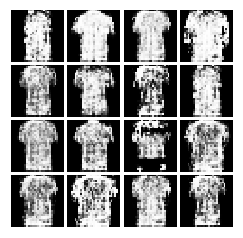

In [89]:
generate("t-shirt")

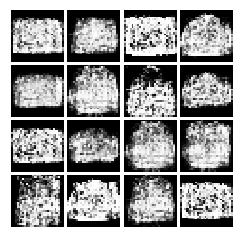

In [90]:
generate("bag") #Doesnt look too much like a bag but it works for the simple model that i used 

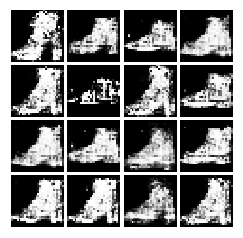

In [91]:
generate("ankle boot")

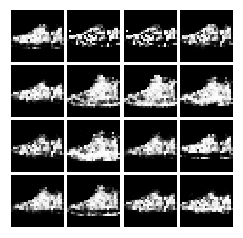

In [92]:
generate("sneaker")